# EK381 Exploratory Data Analysis <br> Lab 4: Continuous Random Variables and Fitting Distributions

### This lab was completed by Rawisara Chairat.

In this lab, we will introduce continuous random variables. Formally, we defined a continuous random variable in Video 3.1 to be a random variable with a continuous cumulative distribution function (CDF) that is differentiable almost everywhere. Informally, it is easier to remember that the range of a continuous random variable $X$ is a continuum (i.e., an interval of the real line) and that the probability that it takes any fixed value $x$ is always zero, $\mathbb{P}[X = x] = 0$. As we saw in the video, it is often convenient to work the probability density function (PDF), rather than the CDF. However, one issue is that, in practice, we cannot collect infinitely many observations, and thus we will never observe every possible value in the range. This leaves us with an important question:
- How can we plot our data in away that we provides a better approximation of the PDF with more observations, even if we never see every value?

As we will see below, histograms are still a good visualization, but we will need to change how we count values. Overall, this lab will provide you with visualizations of Uniform, Exponential, and Gaussian PDFs. We will then try fitting distributions to synthetic data as well as real data from a [breast cancer cell dataset](https://archive.ics.uci.edu/dataset/17/breast+cancer+wisconsin+diagnostic). Finally, we will build a very simple algorithm for classifying cells as benign or malignant based on a measurement and see how well it performs.

In [1]:
#numpy is a package for working with arrays, linear algebra, etc. and stands for "numerical Python".
import numpy as np
#pandas is a package for working with data frames.
import pandas as pd
#matplotlib is a plotting library that mimics Matlab conventions.
import matplotlib.pyplot as plt
#seaborn is a data visualization package.
import seaborn as sns
#scipy.stats is a statistics library
import scipy.stats as st

Let's start by creating some PDF plots using built-in functions. Specifically, let's try to create plots for each of the families of continuous RVs introduced in Video 3.1. In `scipy.stats`, these have intuitive names: `uniform` for Uniform, `expon` for Exponential, and `norm` for Gaussian, which is also referred to as a "normal" distribution. Each distribution has an associated `pdf` function to generate the PDF values for given parameters.

Let's start with the easiest case, the Uniform$(a,b)$ distribution. The `scipy` implementation of this distribution uses `loc` (for location) and `scale` as parameters, with the distribution taking values between `loc` and `loc+scale` so we should set `loc = a` and `scale = b-a`. Get a sense for the distribution by playing with the parameters `a` and `b` below and running the cell to generate a plot.

Text(0.5, 1.0, 'Uniform(0,1) PDF')

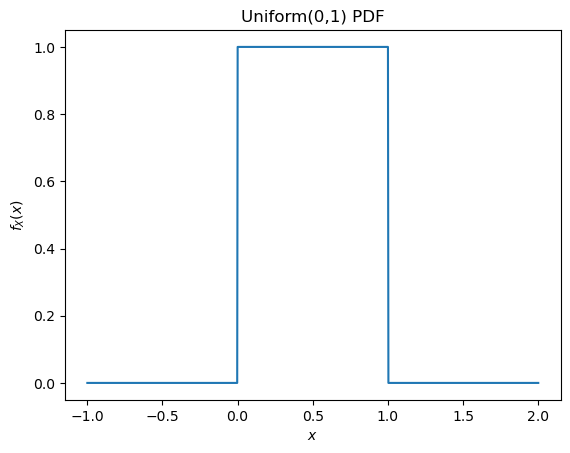

In [2]:
a = 0
b = 1
uniform_range = np.linspace(a-1, b+1, 1000) #Range of values to plot
uniform_pdf = st.uniform.pdf(uniform_range,loc=a,scale=b-a) #PDF values over the range
plt.plot(uniform_range,uniform_pdf) #Plot the PDF values
plt.ylabel("$f_X(x)$") #Create the ylabel
plt.xlabel("$x$") #Create the xlabel
plt.title(f"Uniform({a},{b}) PDF")
#The "f" preceding the title string allows the parameter value to plug into the title with {p}.
#You don't need to do use this mode if you don't want to.


Next, let's plot the Exponential$(\lambda)$ distribution. The `scipy` implementation `expon` uses `scale` as a parameter (since `lambda` is reserved for special "anonymous functions" in Python). All we need to do is set `scale =` $1/ \lambda$. Get a sense for the distribution by playing with `lam` below and running the cell to generate a plot.

Text(0.5, 1.0, 'Exponential(2) PDF')

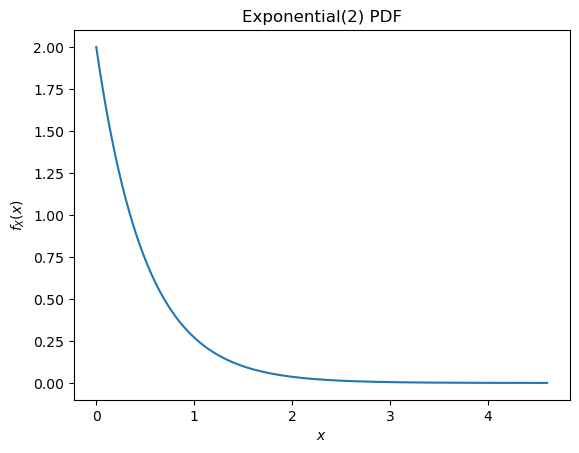

In [3]:
lam = 2
expon_range = np.linspace(0, st.expon.ppf(0.99), 1000) #Range of values to plot (up to CDF=0.99)
expon_pdf = st.expon.pdf(expon_range,scale=1/lam) #PDF values over the range
plt.plot(expon_range,expon_pdf) #Plot the PDF values
plt.ylabel("$f_X(x)$") #Create the ylabel
plt.xlabel("$x$") #Create the xlabel
plt.title(f"Exponential({lam}) PDF")

Finally, let's plot the Gaussian$(\mu,\sigma^2)$ distribution. The `scipy` implementation `norm` uses `loc` for the mean and `scale` for the standard deviation (i.e., the square root of the variance), so we should set `loc =` $\mu$ and `scale =` $\sigma$. Get a sense for the distribution by playing with `mu` and `sigma` below and running the cell to generate a plot.

Text(0.5, 1.0, 'Gaussian(0,1) PDF')

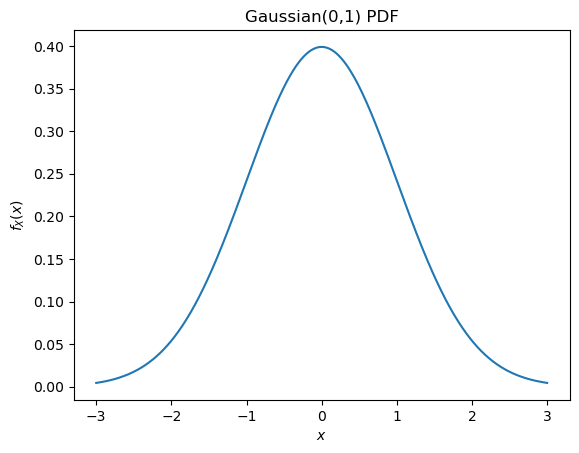

In [4]:
mu = 0 #mean parameter
sigma = 1 #standard deviation parameter (i.e., square root of the variance)
gaussian_range = np.linspace(mu-3*sigma,mu+3*sigma,1000) #Range of values to plot
gaussian_pdf = st.norm.pdf(gaussian_range,mu,sigma) #PDF values over the range
plt.plot(gaussian_range,gaussian_pdf,label="Gaussian PDF") #Plot the PDF values
plt.ylabel("$f_X(x)$") #Create the ylabel
plt.xlabel("$x$") #Create the xlabel
plt.title(f"Gaussian({mu},{sigma**2}) PDF")
#Note that the title is squaring sigma so that we are correctly writing the parameters in terms
#of the mean and variance.

Now, let's generate some synthetic Gaussian data and see how what goes wrong with our usual `value_counts` histogram.

In [5]:
num_trials = 25 #Number of trials to generate.
gaussian_trials = st.norm.rvs(mu,sigma,size=num_trials) #Generate the random variables as a list.
gaussian_df = pd.DataFrame({"Outcome":gaussian_trials}) #Convert the list to a pandas DataFrame.
gaussian_df

,Outcome
0,0.019819
1,-0.368971
2,-0.374302
3,0.107809
4,-2.295457
5,-0.370651
6,0.753883
7,1.760169
8,0.119062
9,0.935534


<Axes: xlabel='Outcome'>

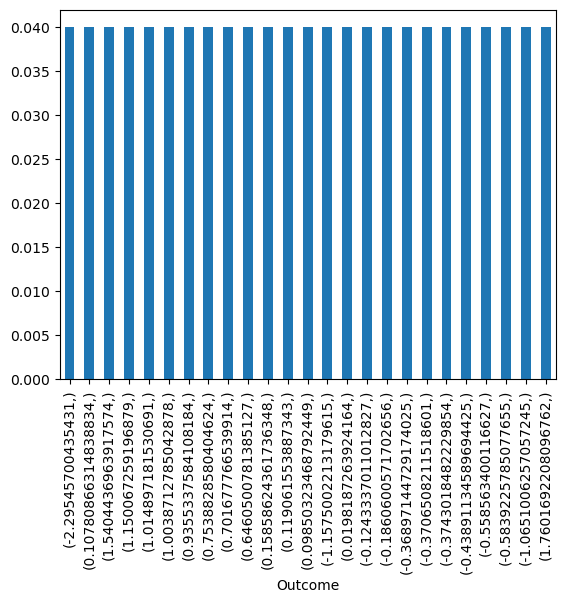

In [6]:
gaussian_df.sort_values(by=["Outcome"]).value_counts(normalize=True).plot(kind = "bar")

The histogram above does not resemble the Gaussian PDF from which the random values were generated. What is going on? The issue is that `value_counts()` counts the occurrences for each unique value, and, for a continuous random variable, every value is going to be unique. (On a computer, you might eventually start seeing overlap once the number of trials exceeds the numerical precision, but we are very far away from that.) How can we get around this issue? One approach is to instead try to plot the empirical CDF. The code below does this for us.

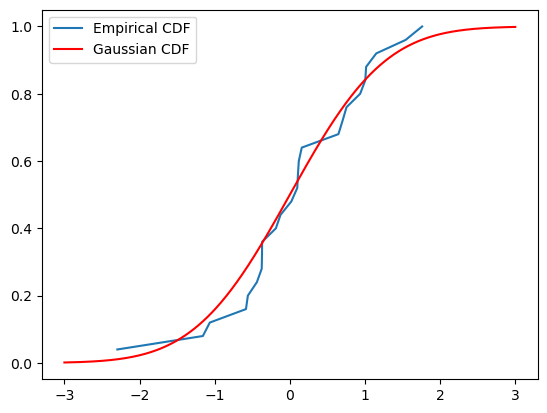

In [7]:
#Sort the values into increasing order.
ecdf_x = gaussian_df.sort_values(by=["Outcome"])
#Count the number of occurrences of unique values *and* take the cumulative sum to get a CDF.
ecdf_y = ecdf_x.value_counts(normalize=True).cumsum()
#Plot the empirical CDF estimated from the CDF.
plt.plot(ecdf_x,ecdf_y,label="Empirical CDF")
#Plot the Gaussian CDF for comparison.
gaussian_cdf = st.norm.cdf(gaussian_range,mu,sigma)
plt.plot(gaussian_range,gaussian_cdf,color="red",label="Gaussian CDF")
plt.legend()

You should see that, even for 25 trials, the empirical CDF is a reasonable approximation of the true Gaussian CDF. If you increase the number of trials and rerun the appropriate cells, you should see the empirical CDF converge to the true CDF (even as the naive histogram plot becomes harder and harder to read).

Is there a way we can plot a histogram for continuous random variables that approximates the PDF? It turns out we only need to slightly modify how we count values. The `value_counts` function keeps track of the number of occurrences of each unique value. As we saw above, this will not work. Instead, why don't we use a few bins, each representing a small interval, and count how many values fall into each bin.

To give a very simple example, say we use three bins, the first from -5 to -2, the second from -2 to +2, and the third from +2 to +5, to classify a few observations. For instance, say we observe 1.95, -3.47, 4.21, -0.56, 2.33, -1.22, and 0.34. This would yields one observation in the bin from -5 to -2, four observations in the bin from -2 to +2, and two observations in the bin from +2 to +5. From here, we can create a histogram.

The only change from before is that we are now counting values in intervals, and we need to decide how to select the number of bins and the associated intervals. The `plt.hist` function uses 10 bins as a default value. Below, we create a histogram for a Gaussian dataset with 25 trials, and plot the corresponding PDF on top.  

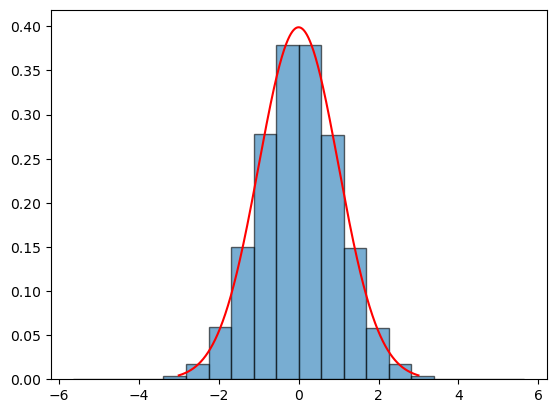

In [43]:
#Below, the density=True setting plots the counts divided by the total number of trials,
#so that we can compare with the PDF. The edgecolor="black" setting draws lines between
#the histogram rectangles, and the alpha=0.6 setting makes the plot more transparent so
#the PDF plot is more visible on top.
num_trials = 100000000
num_bins = 20
gaussian_trials = st.norm.rvs(mu,sigma,size=num_trials) #Generate the random variables as a list.
gaussian_df = pd.DataFrame({"Outcome":gaussian_trials}) #Convert the list to a pandas DataFrame.
plt.hist(gaussian_df["Outcome"],density=True,edgecolor="black",alpha=0.6,bins=num_bins)
mu = 0 #mean parameter
sigma = 1 #standard deviation parameter (i.e., square root of the variance)
gaussian_range = np.linspace(mu-3*sigma,mu+3*sigma,1000) #Range of values to plot
gaussian_pdf = st.norm.pdf(gaussian_range,mu,sigma) #PDF values over the range
plt.plot(gaussian_range,gaussian_pdf,color="red") #Plot the PDF values

---
####  <span style="color:blue">L4.1 What happens if you increase the number of bins while keeping the number of trials small (say fixed to 25)?  </span>
---
#### Answer: Increase the number of bins will increase the number of histogram in the plot, as well as the peak value.

---
####  <span style="color:blue">L4.2 Increase both the number of trials and the number of bins until the histogram looks reasonably well-approximated by the Gaussian PDF. What values did you end up using? </span>
---
#### Answer: 100,000,000 for number of trials and 20 for number of bins

---
####  <span style="color:blue">L4.3 In the cell below, generate Exponential(3) data, plot a histogram of this data with `plt.hist`, and plot the corresponding PDF on the same figure. Select the number of trials and the number of bins so that the histogram is relatively similar to the PDF.</span>
---
Hint: The only command you haven't seen yet that you will need is `st.expon.rvs` to generate the synthetic random data, which will take `scale` and `size` (i.e., number of trials) as inputs.

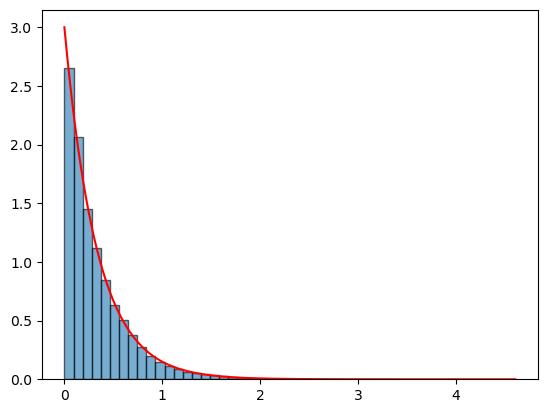

In [123]:
num_trials = 10000
num_bins = 30
lam = 3
expon_trials = st.expon.rvs(scale = 1/lam,size=num_trials) #Generate the random variables as a list.

plt.hist(expon_trials,density=True,edgecolor="black",alpha=0.6,bins=num_bins)
expon_range = np.linspace(0, st.expon.ppf(0.99), 1000) #Range of values to plot (up to CDF=0.99)
expon_pdf = st.expon.pdf(expon_range,scale=1/lam) #PDF values over the range
plt.plot(expon_range,expon_pdf,color="red") #Plot the PDF values

Now, let's load a real dataset and see if some of these continuous distributions are a good fit. The [Diagnostic Wisconsin Breast Cancer Database](https://archive.ics.uci.edu/dataset/17/breast+cancer+wisconsin+diagnostic) is a collection of measurements based on the images of cells collected from benign and malignant tissues as part of the paper W. Street, W. Wolberg, O. Mangasarian, "Nuclear feature extraction for breast tumor diagnosis," Electronic Imaging, 1993. ([PDF Link](https://minds.wisconsin.edu/bitstream/1793/59692/1/TR1131.pdf)) Once you load the dataset below, you will see there are 12 columns: an ID column, a diagnosis column that contains "B" for benign and "M" for malignant, and 10 additional columns corresponding to different features (e.g., Texture, Perimeter). The goal of the dataset is to study how well these features can be used to classify cells as benign or malignant, and we will consider that question directly in a subsequent lab.

In [57]:
bc_df = pd.read_csv("datasets/breastcancercells.csv") #Put the path to the dataset here.
bc_df

,Unnamed: 0,ID Number,Diagnosis,Radius,Texture,Perimeter,Area,Smoothness,Compactness,Concavity,Concave Points,Symmetry,Fractal Dimension
0,0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.30010,0.14710,0.2419,0.07871
1,1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.08690,0.07017,0.1812,0.05667
2,2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.19740,0.12790,0.2069,0.05999
3,3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.24140,0.10520,0.2597,0.09744
4,4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.19800,0.10430,0.1809,0.05883
...,...,...,...,...,...,...,...,...,...,...,...,...,...
564,564,926424,M,21.56,22.39,142.00,1479.0,0.11100,0.11590,0.24390,0.13890,0.1726,0.05623
565,565,926682,M,20.13,28.25,131.20,1261.0,0.09780,0.10340,0.14400,0.09791,0.1752,0.05533
566,566,926954,M,16.60,28.08,108.30,858.1,0.08455,0.10230,0.09251,0.05302,0.1590,0.05648
567,567,927241,M,20.60,29.33,140.10,1265.0,0.11780,0.27700,0.35140,0.15200,0.2397,0.07016


Below, we've plotted a histogram for the Smoothness column along with a Gaussian PDF whose mean and standard deviation are fitted from the dataset. Overall, the Gaussian distribution seems like a good fit for this column visually.

Text(0.5, 1.0, 'Smoothness Histogram and Fitted Gaussian Distribution')

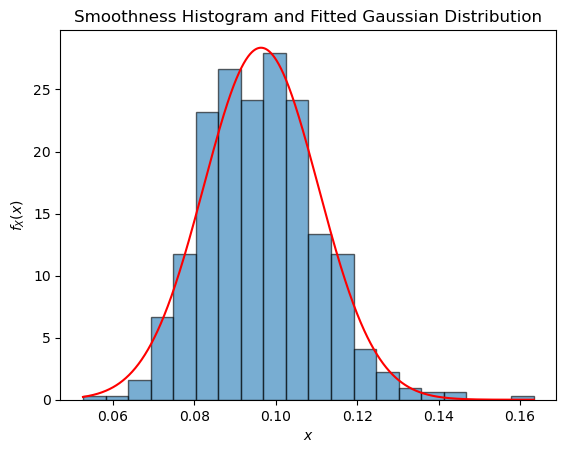

In [58]:
df = bc_df["Smoothness"] #Create a temporary dataframe with the feature we want to plot.
plt.hist(df,density=True,edgecolor="black",alpha=0.6,bins=20) #Plot a histogram of the feature.
gaussian_range = np.linspace(df.min(),df.max(),1000) #Use the dataframe min and max values to establish a range for PDF plotting.
gaussian_pdf = st.norm.pdf(gaussian_range,df.mean(),df.std()) #Create a Gaussian PDF using the mean and standard deviation from the dataframe.
plt.plot(gaussian_range,gaussian_pdf,color="red") #Plot the PDF.
plt.xlabel("$x$")
plt.ylabel("$f_X(x)$")
plt.title("Smoothness Histogram and Fitted Gaussian Distribution")

---
####  <span style="color:blue">L4.4 Plot the histogram and fitted Gaussian PDF for the "Radius" column. Is the correspondence between the histogram and the PDF as close as above? </span>
---
#### Answer: No, it is not as close as above.

Text(0.5, 1.0, 'Radius Histogram and Fitted Gaussian Distribution')

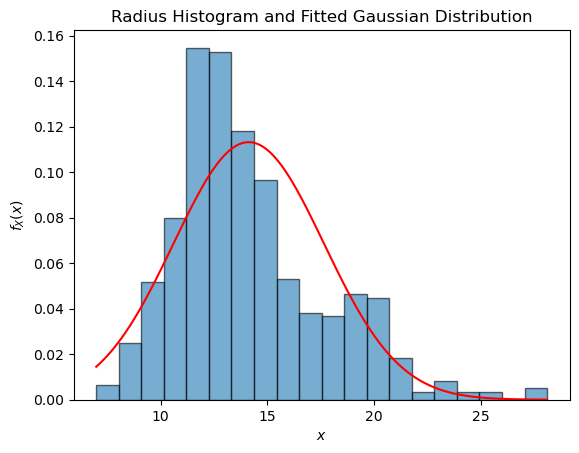

In [60]:
df = bc_df["Radius"] #Create a temporary dataframe with the feature we want to plot.
plt.hist(df,density=True,edgecolor="black",alpha=0.6,bins=20) #Plot a histogram of the feature.
gaussian_range = np.linspace(df.min(),df.max(),1000) #Use the dataframe min and max values to establish a range for PDF plotting.
gaussian_pdf = st.norm.pdf(gaussian_range,df.mean(),df.std()) #Create a Gaussian PDF using the mean and standard deviation from the dataframe.
plt.plot(gaussian_range,gaussian_pdf,color="red") #Plot the PDF.
plt.xlabel("$x$")
plt.ylabel("$f_X(x)$")
plt.title("Radius Histogram and Fitted Gaussian Distribution")

---
####  <span style="color:blue">L4.5 Using the Diagnosis column, split the dataframe into `benign_df` that contains all the rows with a "B" in the Diagnosis column and `malignant_df` that contains all the rows with a "M" in the Diagnosis column. </span>
---
Hint: You can see how to do this in Lab 3 or you can ask an AI (e.g., ChatGPT) how to select all rows with a specific column value in pandas.

In [115]:
benign_df = bc_df[bc_df["Diagnosis"] == "B"]
benign_df

,Unnamed: 0,ID Number,Diagnosis,Radius,Texture,Perimeter,Area,Smoothness,Compactness,Concavity,Concave Points,Symmetry,Fractal Dimension
19,19,8510426,B,13.540,14.36,87.46,566.3,0.09779,0.08129,0.06664,0.047810,0.1885,0.05766
20,20,8510653,B,13.080,15.71,85.63,520.0,0.10750,0.12700,0.04568,0.031100,0.1967,0.06811
21,21,8510824,B,9.504,12.44,60.34,273.9,0.10240,0.06492,0.02956,0.020760,0.1815,0.06905
37,37,854941,B,13.030,18.42,82.61,523.8,0.08983,0.03766,0.02562,0.029230,0.1467,0.05863
46,46,85713702,B,8.196,16.84,51.71,201.9,0.08600,0.05943,0.01588,0.005917,0.1769,0.06503
...,...,...,...,...,...,...,...,...,...,...,...,...,...
558,558,925277,B,14.590,22.68,96.39,657.1,0.08473,0.13300,0.10290,0.037360,0.1454,0.06147
559,559,925291,B,11.510,23.93,74.52,403.5,0.09261,0.10210,0.11120,0.041050,0.1388,0.06570
560,560,925292,B,14.050,27.15,91.38,600.4,0.09929,0.11260,0.04462,0.043040,0.1537,0.06171
561,561,925311,B,11.200,29.37,70.67,386.0,0.07449,0.03558,0.00000,0.000000,0.1060,0.05502


In [116]:
malignant_df = bc_df[bc_df["Diagnosis"] == "M"]
malignant_df

,Unnamed: 0,ID Number,Diagnosis,Radius,Texture,Perimeter,Area,Smoothness,Compactness,Concavity,Concave Points,Symmetry,Fractal Dimension
0,0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.30010,0.14710,0.2419,0.07871
1,1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.08690,0.07017,0.1812,0.05667
2,2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.19740,0.12790,0.2069,0.05999
3,3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.24140,0.10520,0.2597,0.09744
4,4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.19800,0.10430,0.1809,0.05883
...,...,...,...,...,...,...,...,...,...,...,...,...,...
563,563,926125,M,20.92,25.09,143.00,1347.0,0.10990,0.22360,0.31740,0.14740,0.2149,0.06879
564,564,926424,M,21.56,22.39,142.00,1479.0,0.11100,0.11590,0.24390,0.13890,0.1726,0.05623
565,565,926682,M,20.13,28.25,131.20,1261.0,0.09780,0.10340,0.14400,0.09791,0.1752,0.05533
566,566,926954,M,16.60,28.08,108.30,858.1,0.08455,0.10230,0.09251,0.05302,0.1590,0.05648


---
####  <span style="color:blue">L4.6 Determine the mean and standard deviation for the Radius column for both the `benign_df` and the `malignant_df` dataframes.  </span>
---

In [117]:
df = benign_df["Radius"]
benign_mean = df.mean()
print("Benign Mean:",benign_mean)

Benign Mean: 12.146523809523808


In [118]:
benign_std = df.std()
benign_std
print("Benign Standard Deviation:",benign_std)

Benign Standard Deviation: 1.7805116461410386


In [119]:
df = malignant_df["Radius"]
malignant_mean = df.mean()
print("Malignant Mean:",malignant_mean)

Malignant Mean: 17.462830188679245


In [120]:
malignant_std = df.std()
malignant_std
print("Malignant Standard Deviation:",malignant_std)

Malignant Standard Deviation: 3.2039711007793663


You should get that the difference between the benign mean radius and the malignant mean radius is larger than a standard deviation (even going by the larger malignant standard deviation). This means we should see reasonable separation between the histograms (and fitted distributions) on a plot. Let's try that below.

---
####  <span style="color:blue">L4.7 Create a single plot that contains the following:
- A blue histogram with 20 bins for the benign radius data.
- A blue Gaussian PDF using the benign mean and standard deviation.
- A red histogram with 20 bins for the malignant radius data.
- A red Gaussian PDF using the malignant mean and standard deviation.   </span>
---
Use  `color = "red"` to change the plot color.
Overall, you should see good correspondence between the histograms and fitted PDFs. Recall that earlier the "Radius" column did not match the Gaussian PDF very well. That is because we were seeing a mixture of the benign and malignant distributions. When plotted separately, the benign and malignant radius data look close to Gaussian, each following a different set of parameters.

Text(0.5, 1.0, 'Radius Histogram and Fitted Gaussian Distribution for Benign vs Malignant')

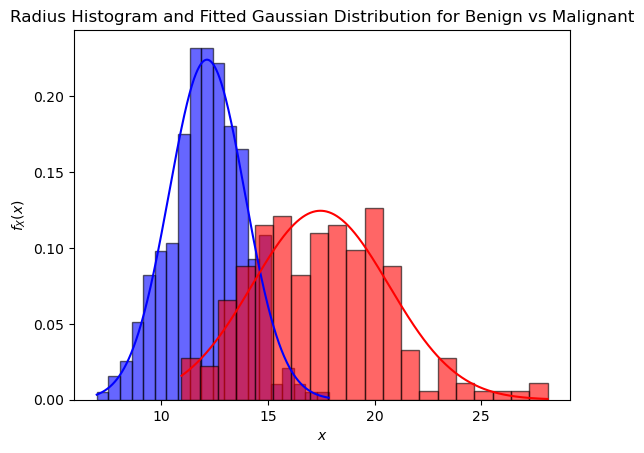

In [69]:
benign_df = benign_df["Radius"] #Create a temporary dataframe with the feature we want to plot.
malignant_df = malignant_df["Radius"]
plt.hist(benign_df,density=True,edgecolor="black",alpha=0.6,bins=20,color="blue") #Plot a histogram of the feature.
plt.hist(malignant_df,density=True,edgecolor="black",alpha=0.6,bins=20,color="red") #Plot a histogram of the feature.
benign_gaussian_range = np.linspace(benign_df.min(),benign_df.max(),1000) #Use the dataframe min and max values to establish a range for PDF plotting.
benign_gaussian_pdf = st.norm.pdf(benign_gaussian_range,benign_df.mean(),benign_df.std()) #Create a Gaussian PDF using the mean and standard deviation from the dataframe.
malignant_gaussian_range = np.linspace(malignant_df.min(),malignant_df.max(),1000) #Use the dataframe min and max values to establish a range for PDF plotting.
malignant_gaussian_pdf = st.norm.pdf(malignant_gaussian_range,malignant_df.mean(),malignant_df.std()) #Create a Gaussian PDF using the mean and standard deviation from the dataframe.
plt.plot(benign_gaussian_range,benign_gaussian_pdf,color="blue") #Plot the PDF.
plt.plot(malignant_gaussian_range,malignant_gaussian_pdf,color="red") #Plot the PDF.
plt.xlabel("$x$")
plt.ylabel("$f_X(x)$")
plt.title("Radius Histogram and Fitted Gaussian Distribution for Benign vs Malignant")

Let's make a first attempt at a simple classification algorithm that guesses if a cell is benign or malignant based *only* on its radius. In Chapter 6, we will focus on these classification (i.e., detection) algorithms in more depth, and understand how to optimally make decisions as well as how to make decisions using multiple features. Looking at your plot, you should see that for a radius 15 or greater, cells tend to be malignant. Let's use this as our threshold and guess that a cell is malignant if its radius is 15 or larger. Below, your job is to answer two questions:

- What is the probability of a "missed detection," i.e., what fraction of the malignant cells would be misclassified as benign since their radius is below 15?
- What is the probability of a "false alarm," i.e., what fraction of the benign cells would be misclassified as malignant since their radius is 15 or above?
Note that the false alarm probability **is not** one minus the missed detection probability, since these are based on different datasets.

---
####  <span style="color:blue">L4.8 Using the `value_counts(normalize=True)` command, determine the missed detection and false alarm probabilities. Note that you should first apply your logical condition. For example, you should first evaluate `(malignant_df["Radius"] < 15)` before counting.
---

#### Answer: The missed detection probability is 0.240566. The false alarm probability is 0.036415.

In [124]:
malignant_df = bc_df[bc_df["Diagnosis"] == "M"]
(malignant_df["Radius"] < 15).value_counts(normalize=True)

Radius
False    0.759434
True     0.240566
Name: proportion, dtype: float64

In [125]:
benign_df = bc_df[bc_df["Diagnosis"] == "B"]
(benign_df["Radius"] < 15).value_counts(normalize=True)

Radius
True     0.963585
False    0.036415
Name: proportion, dtype: float64